Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 7: Download Imagery from Google Earth Engine for Time Series Analysis 
===============================================================


Here we will be downloading imagery from Google Earth Engine to look at sea surface temperature variations over time. 

>[Google Earth Engine](https://earthengine.google.com) combines a multi-petabyte catalog of satellite imagery and geospatial datasets with planetary-scale analysis capabilities and makes it available for scientists, researchers, and developers to detect changes, map trends, and quantify differences on the Earth's surface.

This platform allows you to leverage the benefit of datasets already in the cloud, process them in parallel, and either run analysis in the cloud or pull data down locally to analyze. Here our goal is to download a stack of [MODIS](https://modis.gsfc.nasa.gov/about/) (or Moderate Resolution Imaging Spectroradiometer) data where each band is a daily value of sea surface temperature measured by the satellite. 

You will need an account, which is available freely from Google and can then access the code used to generate these temporal stacks of SST available here: https://code.earthengine.google.com/bbf2eac7fd8f59e85ba54e5914dedc3c. This data is already available in the `data/` directory but we highly recommend you run through the GEE code and download from there in order to understand the full workflow.

After visualizing and cleaning this data we'll be running a quick harmonic time series analysis using the python package `seasonal` https://github.com/welch/seasonal. 

### Inspecting MODIS SST Data
Assuming you have these files located `data/` with the three images called `pamlicoStackedSST.tif`, `gulfstreamStackedSST.tif`, and `hatterasGulfStackedSST.tif` let's get started!

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First let's pull in the SST image dataset for the Pamlico Sound. As usual let's check out the metadata for this raster:

In [2]:
# Open our raster dataset
dataset = rasterio.open('../data/pamlicoStackedSST.tif')
pamlico_image = dataset.read()

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj)

dataset.close()

Number of bands in image: 1096

Image size is: 144 rows x 213 columns

Raster driver: GTiff

Image projection:
EPSG:4326


Now let's visualize it, knowing that it won't look totally normal since this is a 500m resolution image of just sea surface temperature.

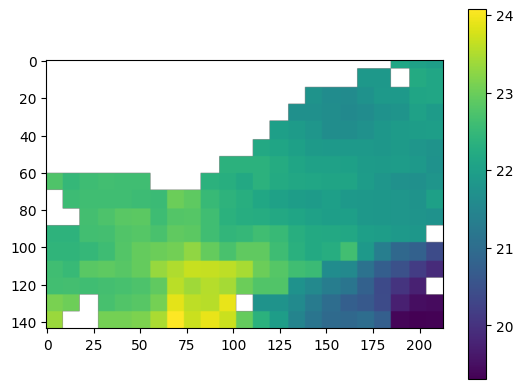

In [3]:
fig, ax = plt.subplots()
img = ax.imshow(pamlico_image[500,:,:])
fig.colorbar(img, ax=ax) # we have to pass the current plot as an argument thus have to set it as a variable

Now let's pull in the SST image dataset for the section of the Gulf Stream just off Cape Lookout, North Carolina.

In [4]:
# Open our raster dataset
dataset = rasterio.open('../data/gulfstreamStackedSST.tif')
gulfstream_image = dataset.read()

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj)

dataset.close()

Number of bands in image: 1096

Image size is: 96 rows x 121 columns

Raster driver: GTiff

Image projection:
EPSG:4326


Again we'll visualize.

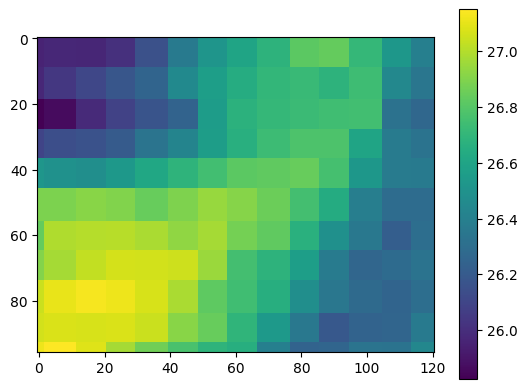

In [5]:
fig, ax = plt.subplots()
img = ax.imshow(gulfstream_image[500,:,:])
fig.colorbar(img, ax=ax) # we have to pass the current plot as an argument thus have to set it as a variable

Let's check where these rasters are located just to ensure we have the context of the environment we're inspecting:

In [6]:
import rasterio.features
import rasterio.warp

raster_fps = ['../data/gulfstreamStackedSST.tif',
             '../data/pamlicoStackedSST.tif',
             '../data/hatterasGulfStackedSST.tif']

raster_footprints = []

for fp in raster_fps:

    with rasterio.open(fp) as dataset:

        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            raster_footprints.append([
                rasterio.warp.transform_geom(dataset.crs, 'EPSG:4326', geom, precision=6),
                fp.split('/')[-1]
            ])
        

In [7]:
import folium # let's make an interactive map using leaflet

# create the folium map object
m = folium.Map(location=[34.33361, -75.552807], zoom_start=7) # set the map centered around the first point

# this actually adds the polygon to the map based on the geojson we extracted earlier
for footprint in raster_footprints:
    folium.GeoJson(
        footprint[0],
        tooltip=footprint[1]
    ).add_to(m)


m

This looks good! Though do note that this is the minimum bounding box of each raster and not the actual footprint, the Pamlico Sound raster does not include land.

Now let's plot the data across time.

In [8]:
np.nanmean(pamlico_image.reshape((pamlico_image.shape[0], -1)),axis=1)

C:\Users\myriampe\AppData\Local\Temp\ipykernel_5568\1661822449.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(pamlico_image.reshape((pamlico_image.shape[0], -1)),axis=1)


array([      nan, 17.071318,       nan, ...,       nan,       nan,
             nan], dtype=float32)

C:\Users\myriampe\AppData\Local\Temp\ipykernel_5568\942350912.py:7: RuntimeWarning: Mean of empty slice
  pamlico_y = np.nanmean(pamlico_image.reshape((pamlico_image.shape[0], -1)),axis=1)
C:\Users\myriampe\AppData\Local\Temp\ipykernel_5568\942350912.py:10: RuntimeWarning: Mean of empty slice
  gulfstream_y = np.nanmean(gulfstream_image.reshape((gulfstream_image.shape[0], -1)),axis=1)


Text(0.5, 1.0, 'Gulfstream off Cape Lookout SST 2016-2019')

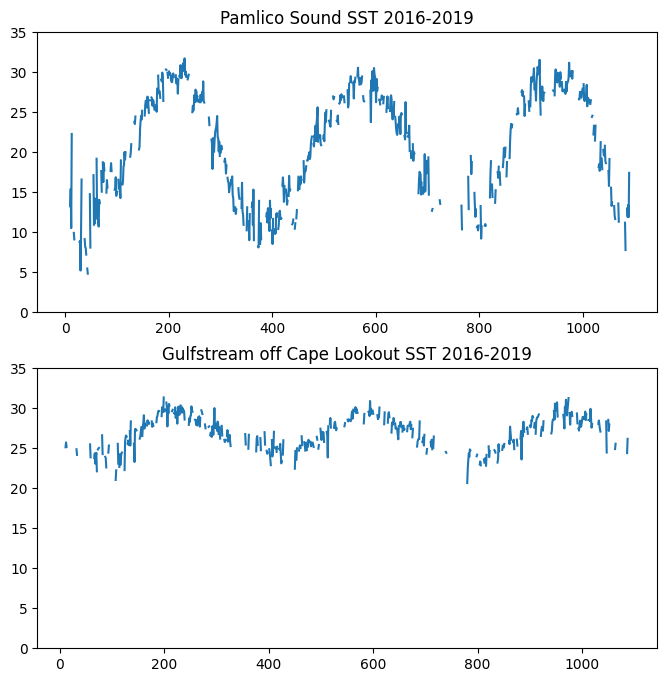

In [9]:
fig, ax = plt.subplots(2,1,figsize=(8,8))

# create a series of x values from 0 to the number of bands in the image
x = np.arange(pamlico_image.shape[0])
# now we need to reshape the image from [bands, rows, col] to [bands, vector of pixel values] and then take the
# mean but ignore nan pixels, this will still leave us with some timesteps where all pixels are nan as we'll see 
pamlico_y = np.nanmean(pamlico_image.reshape((pamlico_image.shape[0], -1)),axis=1)

# do the same for the gulfstream image
gulfstream_y = np.nanmean(gulfstream_image.reshape((gulfstream_image.shape[0], -1)),axis=1)

# plot them as lines
ax[0].plot(x, pamlico_y)
ax[0].set_ylim(0,35)
ax[0].set_title("Pamlico Sound SST 2016-2019")

ax[1].plot(x, gulfstream_y)
ax[1].set_ylim(0,35)
ax[1].set_title("Gulfstream off Cape Lookout SST 2016-2019")

But as we can see above and here that we have lots of missing data:

In [10]:
np.isnan(pamlico_y)

array([ True, False,  True, ...,  True,  True,  True])

Quite a lot of missing data. We can assume most of this is from cloud coverage:

In [11]:
print("Num of timesteps:", len(pamlico_y))
print("Missing data count:", len(np.argwhere(np.isnan(pamlico_y))))

Num of timesteps: 1096
Missing data count: 397


We can fill this in by simply interpolating across the vector to fill in holes with nearby data:

C:\Users\myriampe\AppData\Local\Temp\ipykernel_5568\1035006620.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


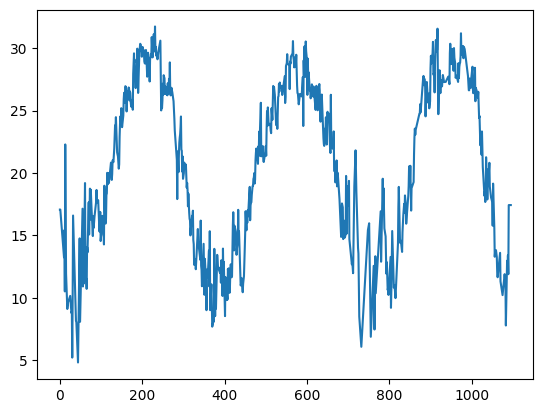

In [12]:
# Fill in NaN's by creating a mask of all NaNs and then interpolating them from existing data
mask = np.isnan(pamlico_y)
pamlico_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), pamlico_y[~mask])

fig, ax = plt.subplots()

ax.plot(x, pamlico_y)
fig.show()

### Time Series Analysis

Bringing in `seasonal` now let's look at a simple toy example of data with some seasonality to it and extract the trend and the residual error.

For more details on this specific harmonic analysis technique check out https://github.com/welch/seasonal

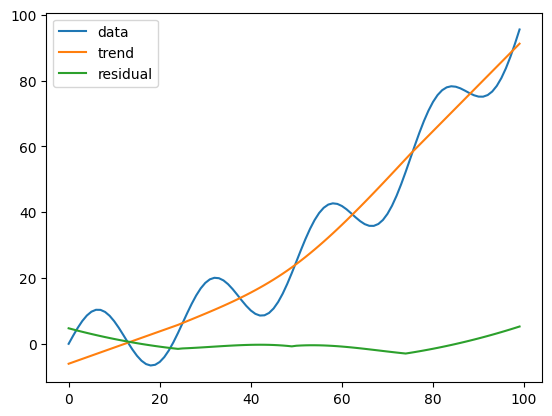

In [13]:
from seasonal import fit_seasons, adjust_seasons
import math

# make a trended sine wave
s = [10 * math.sin(i * 2 * math.pi / 25) + i * i /100.0 for i in range(100)]
# detrend and deseasonalize
seasons, trend = fit_seasons(s)
adjusted = adjust_seasons(s, seasons=seasons)
residual = adjusted - trend

fig, ax = plt.subplots()

ax.plot(s, label='data')
ax.plot(trend, label='trend')
ax.plot(residual, label='residual')
ax.legend(loc='best')

Let's give it a try on our data now, starting with the SST image covering three years of Pamlico Sound

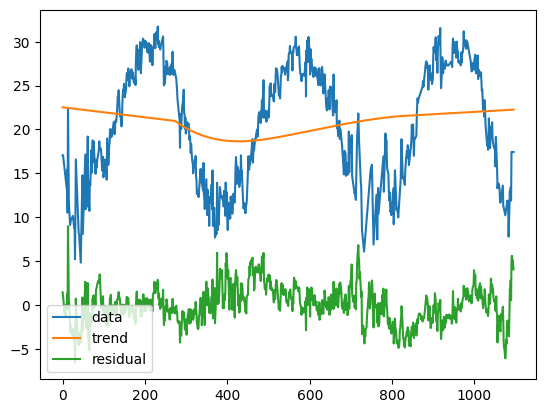

In [14]:
seasons, trend = fit_seasons(pamlico_y)
adjusted = adjust_seasons(pamlico_y, seasons=seasons)
residual = adjusted - trend

fig, ax = plt.subplots()

ax.plot(pamlico_y, label='data')
ax.plot(trend, label='trend')
ax.plot(residual, label='residual')
ax.legend(loc='lower left')

Now let's pull in a much longer time series of a slightly smaller area in the Gulf Stream, again letting Google Earth Engine do the heavy lifting in filtering through the data and feeding us only our small spatial area of interest at each timestep. This may take a moment since it is such a dense time series.

In [15]:
# Open our raster dataset
dataset = rasterio.open('../data/hatterasGulfStackedSST.tif')
long_pamlico_image = dataset.read()

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj)

dataset.close()

Number of bands in image: 6019

Image size is: 28 rows x 33 columns

Raster driver: GTiff

Image projection:
EPSG:4326


While small spatially this image has over 6000 bands! Let's take a look at a random band:

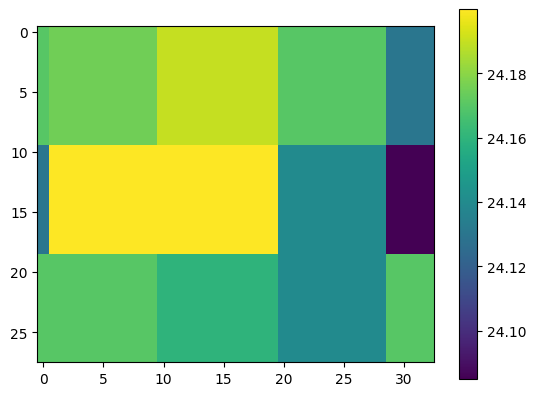

In [16]:
fig, ax = plt.subplots()
img = ax.imshow(long_pamlico_image[1000,:,:])
fig.colorbar(img, ax=ax) # we have to pass the current plot as an argument thus have to set it as a variable

As before let's convert this to a vector and take the mean of each timestep and interpolate out the missing time steps.

In [17]:
hatteras_y = np.nanmean(long_pamlico_image.reshape((long_pamlico_image.shape[0], -1)),axis=1)
long_x = np.arange(long_pamlico_image.shape[0])

# Fill in NaN's...
mask = np.isnan(hatteras_y)
hatteras_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), hatteras_y[~mask])

C:\Users\myriampe\AppData\Local\Temp\ipykernel_5568\885921169.py:1: RuntimeWarning: Mean of empty slice
  hatteras_y = np.nanmean(long_pamlico_image.reshape((long_pamlico_image.shape[0], -1)),axis=1)


Now let's check out the trend in this data:

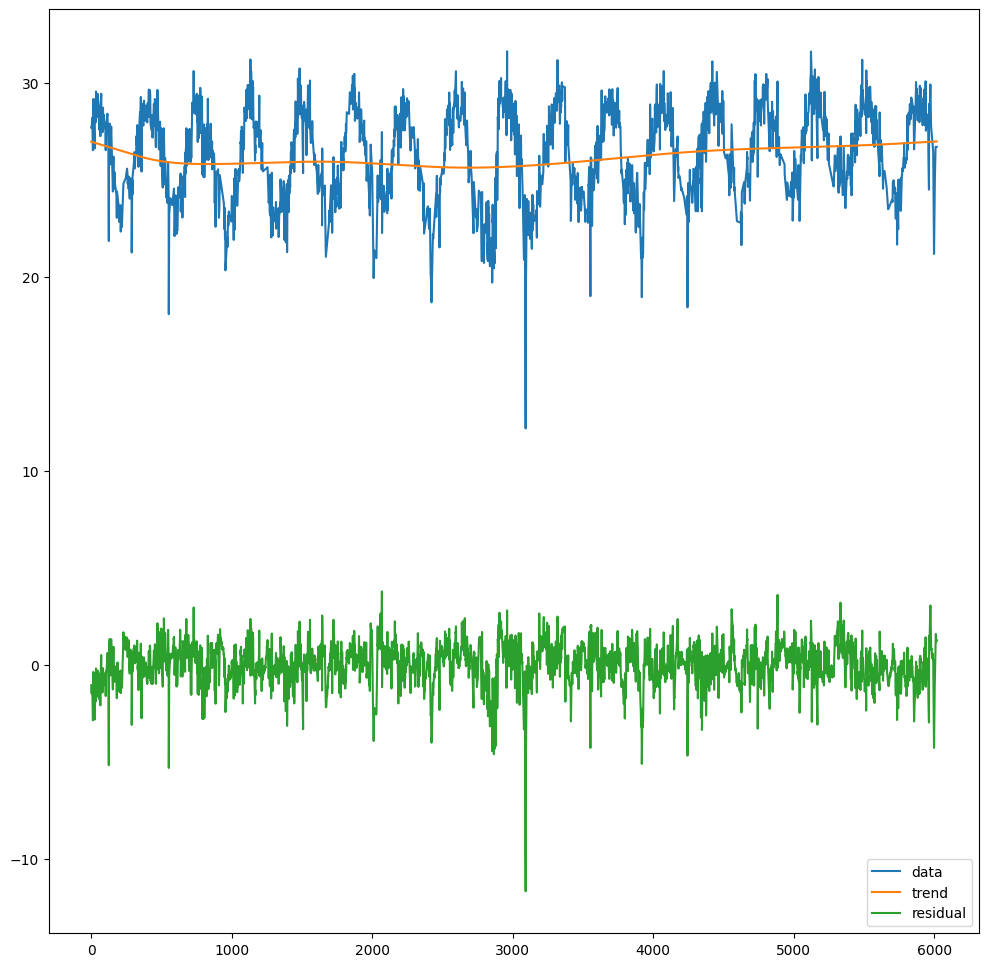

In [18]:
seasons, trend = fit_seasons(hatteras_y)
adjusted = adjust_seasons(hatteras_y, seasons=seasons)
residual = adjusted - trend

fig, ax = plt.subplots(figsize=(12,12))

ax.plot(hatteras_y, label='data')
ax.plot(trend, label='trend')
ax.plot(residual, label='residual')
ax.legend(loc='lower right')

Pretty cool!

## Final Wrap-up and Next Steps

Congrats on making it this far! Here we downloaded MODIS SST imagery from Google Earth Engine, cleaned this data, and analyzed it for seasonality and trends. 

As a final chapter in this series we'll explore `xarray` which is a package for large N-dimensional array manipulation and a powerful set of visualization tools contained within the package `hvplot`:(link to [webpage](chapter_5_xarray_netcdfs.html) or [Notebook](chapter_5_xarray_netcdfs.ipynb)).